In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk
import xlsxwriter
import openpyxl
import os.path
from os.path import exists

import cv2
from skimage import io

import imageio  
import os

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
#UPLOAD CONSOLIDATED TABLE WITH FEATURES
conso_filename = "data_consolidated.csv"
directory = "../data/"
df_data1 = pd.read_csv(directory+conso_filename)
print(len(list(df_data1.columns)))
df_data = df_data1.copy()

#STARTING AT 1
#FUNCTIONS USED TO CREATED DIFFERENT SCALES (1 TO 10, 1 TO 5, 1 TO 4, 1 TO 3, 1 TO 2)
def scale10(n):
    val = 0
    if n <=10: 
        val = 1
    elif n >10 and n<=20:
        val = 2
    elif n >20 and n <=30:
        val = 3
    elif n>30 and n <=40:
        val = 4
    elif n > 40 and n<=50:
        val = 5
    elif n>50 and n<=60:
        val = 6
    elif n>60 and n<=70:
        val = 7
    elif n>70 and n<=80:
        val = 8
    elif n>80 and n<=90:
        val = 9
    else: 
        val = 10
    return(val)

def scale5(n):
    val = 0
    if n <=20: 
        val = 1
    elif n >20 and n<=40:
        val = 2
    elif n >40 and n <=60:
        val = 3
    elif n>60 and n <=80:
        val = 4
    else: val = 5

    return(val)

def scale4(n):
    val = 0
    if n <=25: 
        val = 1
    elif n >25 and n<=50:
        val = 2
    elif n >50 and n <=75:
        val = 3
    else: 
        val = 4

    return(val)

def scale3(n):
    val = 0
    if n <=34: 
        val = 1
    elif n >34 and n<=68:
        val = 2
    else:
        val = 3

    return(val)

def scale2(n):
    val = 0
    if n < 50: 
        val = 1
    else:
        val = 2

    return(val)

#CREATE COLUMNS WITH DIFFERENT SCALES FOR TESTING MODELS
df_data["Scale10"] = df_data.apply(lambda row: scale10(row.Pawpularity), axis=1)
df_data["Scale5"] = df_data.apply(lambda row: scale5(row.Pawpularity), axis=1)
df_data["Scale4"] = df_data.apply(lambda row: scale4(row.Pawpularity), axis=1)
df_data["Scale3"] = df_data.apply(lambda row: scale3(row.Pawpularity), axis=1)
df_data["Scale2"] = df_data.apply(lambda row: scale2(row.Pawpularity), axis=1)

497


In [20]:
#To select the SCALE you want to work with (10, 5, 4, 3, 2)
def assign_y(scale):
    if scale == 2:
        Y_train = train_y2
        Y_dev = dev_y2
    elif scale == 3:
        Y_train = train_y3
        Y_dev = dev_y3
    elif scale == 4:
        Y_train = train_y4
        Y_dev = dev_y4
    elif scale == 5:
        Y_train = train_y5
        Y_dev = dev_y5
    elif scale == 10:
        Y_train = train_y10
        Y_dev = dev_y10
    elif scale == 100:
        Y_train = train_labels
        Y_dev = dev_labels
    else:
        Y_train = train_labels
        Y_dev = dev_labels
    return(Y_train, Y_dev)   

#Return list of mean for each range in scale
def mean_scale(scale, Y_train, train_labels):
    means = []
    start = 1
    for i in range(start,scale+start):
        index_to_get = np.where(Y_train == i)
        me = train_labels[index_to_get].mean()
        means.append(me)
    return(means)  

#Return list of mean for each range in scale
def mean_scale1(scale, Y_train, train_labels,f):
    meantot = train_labels.mean()
    means = []
    start = 1
    for i in range(start,scale+start):
        index_to_get = np.where(Y_train == i)
        me = train_labels[index_to_get].mean()
        means.append(((me+meantot)/2) + f)
    return(means)  

#Return Prediction based on mean for range in scale
def predict_scale(prediction, mean_scale):
    start = 1
    predict_out = []
    n = len(mean_scale)
    for p in prediction:
        predict_out.append(mean_scale[p-start])
    return(predict_out)

def wrt_excel(file, sheet_name, df):
    if os.path.exists(file):
        with pd.ExcelWriter(file, engine="openpyxl", mode='a') as writer:
            df.to_excel(writer, sheet_name=sheet_name)
    else:
        with pd.ExcelWriter(file, engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=sheet_name)
            
#Helper function to show line of cummulative variance explained by each pca
def varplot2(exp_var_ratio):
    
    cum_var_exp= np.cumsum(exp_var_ratio)

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 8))
        #plt.step(range(len(exp_var_ratio)), cum_var_exp, where='mid',label='cumulative explained variance')
        plt.plot(range(len(exp_var_ratio)), cum_var_exp, label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

def print_confusion_matrix(Y_dev, Prediction, title):
    cfm = confusion_matrix(Y_dev,Prediction)
    start = 0 #It does not work
    size = 8
    if np.unique(Y_dev).max() > 5:
        size = 6
    else: 
        size = 3
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(cfm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cfm.shape[0]):
        for j in range(cfm.shape[1]):
            ax.text(x=j+start, y=i+start,s=cfm[i, j], va='center', ha='center', size='xx-large')
    ax.set_title(title)

### Exploring Basic Features

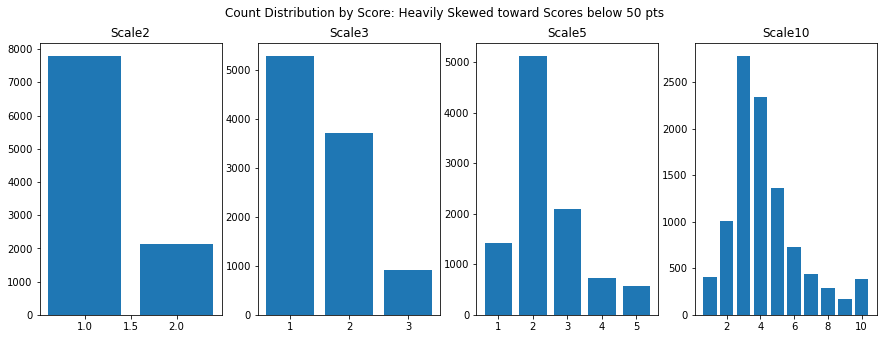

In [4]:
#Set subplot matrix
fig1, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
scales_plot = [2, 3, 5, 10]
fontsize=12
i = 0
for s in scales_plot:
    if s == 100:
        sca = 'Pawpularity'
    else: sca = 'Scale'+str(s)
    df_scale = pd.pivot_table(df_data, index = sca, values = 'Id', aggfunc='count')
    ax[i].bar(list(df_scale.index),list(df_scale['Id']))
    ax[i].set_title(sca, fontsize=fontsize)
    i += 1
fig1.suptitle("Count Distribution by Score: Heavily Skewed toward Scores below 50 pts")
plt.show()

In [ ]:
pd.pivot_table(df_data, index = "Scale2", values = 'Id', aggfunc='count')

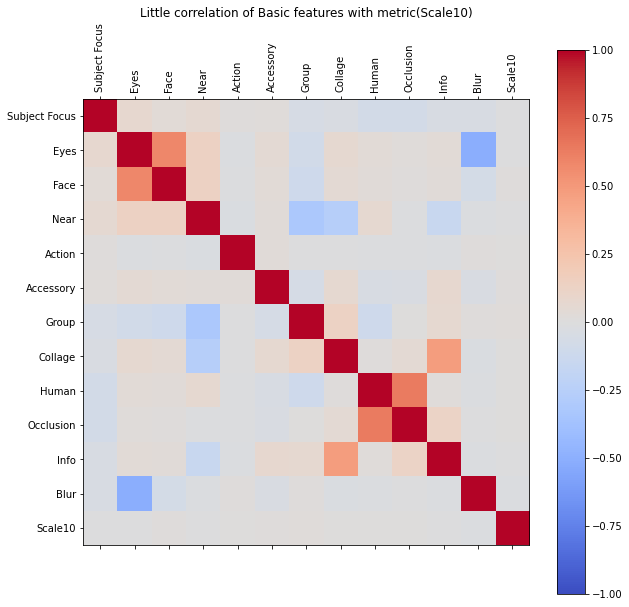

In [5]:
column_names = list(df_data.columns)
coln1 = 2
coln2 = coln1+12
basic_features = column_names[coln1:coln2]

sca = 'Scale10'
features = basic_features + [sca]
data = df_data[features]
corr = data.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.title("Little correlation of Basic features with metric(Scale10)")
plt.show()

In [ ]:
#corr.style.background_gradient(cmap='coolwarm')

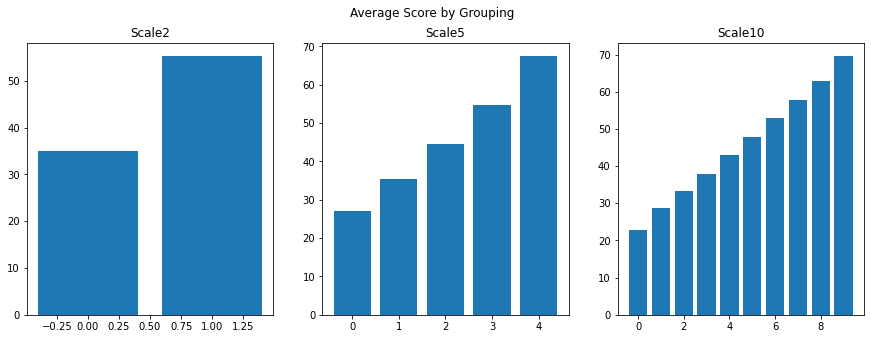

In [6]:
#Set subplot matrix
fig2, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
scales_plot = [2, 5, 10]
fontsize=12
i = 0
for s in scales_plot:
    sca = 'Scale'+str(s)
    means = mean_scale1(s, np.array(df_data[sca]), np.array(df_data["Pawpularity"]),1.333)
    ax1[i].bar(range(0,s),np.array(means))
    ax1[i].set_title(sca, fontsize=fontsize)
    i += 1
fig2.suptitle("Average Score by Grouping")
plt.show()

### Color Pallet

In [7]:
def find_palette(img):
    
    # Find the Average Color, the top five colors for image palette, and top color in palette
    average = img.mean(axis=0).mean(axis=0)
    
    pixels = np.float32(img.reshape(-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    
    dominant = palette[np.argmax(counts)]
    
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    
    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(img.shape[0]*freqs)
       
    return (dominant, average, palette, counts)

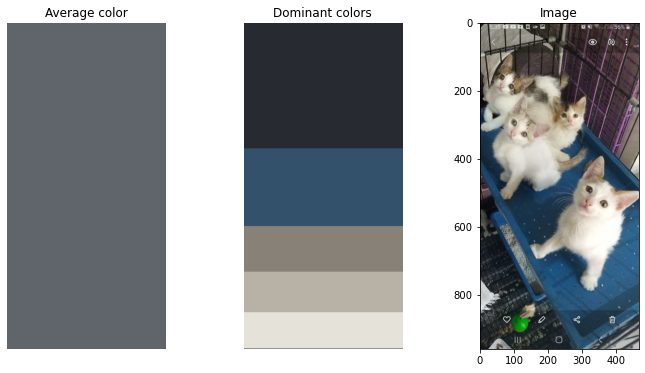

In [8]:
folder = "../data/train/"
image_name = "00a1ae8867e0bb89f061679e1cf29e80.jpg"
# image_name = "00a1e0c0f89ff89a8f32d42e9025f6b2.jpg"

#img = io.imread(image_name)[:, :, :-1]
img = io.imread(folder+image_name)

d, average, palette, counts = find_palette(img)
avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img.shape[0]*freqs)

for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
ax1.imshow(dom_patch)
ax1.set_title('Dominant colors')
ax2.imshow(img)
ax2.set_title('Image')
ax1.axis('off')
plt.show(fig)

### Palette Analysis

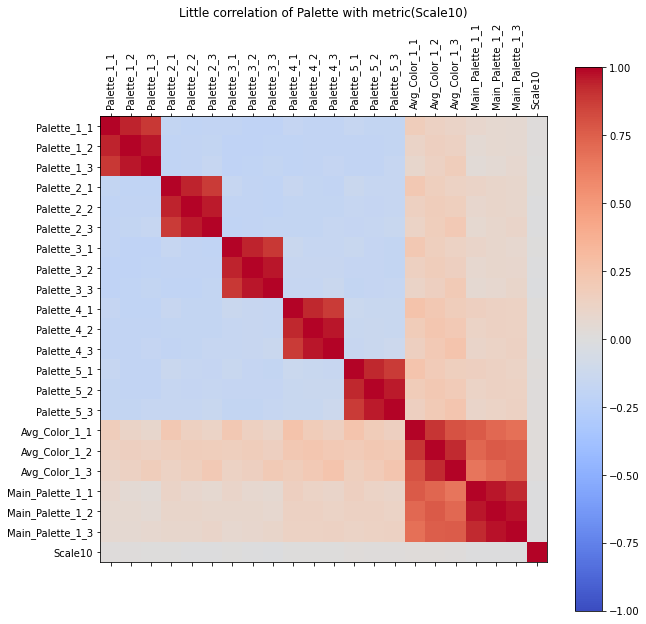

In [9]:
#Top Five Colors for Each Image + Average Color + Most Common Color
column_names = list(df_data.columns)
gap = 21
coln1 = len(column_names) - gap -5
coln2 = coln1 + gap

palette_to_keep = column_names[coln1:coln2]
sca = 'Scale10'
features = palette_to_keep + [sca]
data = df_data[features]
corr = data.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.title("Little correlation of Palette with metric(Scale10)")
plt.show()

In [ ]:
#CODE TO EXTRACT THE COLOR PALETTE FOR ALL IMAGES LOCATED IN PATH.

#path = "../data/train/"
path = "../data/examples/"

mp = np.empty(1, dtype=object)
image_list = []

#GET LIST OF FILES IN PATH
files = os.listdir(path)


#FOR ALL FILES (IMAGES) EXTRACT THE PALETTE
i = 0
for picture in files:
        
    img = io.imread(path+picture)
    d, a, p, counts = find_palette(img)
    p =  p.reshape(1, 5*3)[0]
    
    image_list.append(picture.split('.')[0])
    r = np.append(p,[a,d])
    if len(mp) == 1:
        mp = r
    else: mp = np.vstack([mp, r])
    print("Image: ", i)
    i +=1

#SAVE PALETTE IN A DATAFRAME AND SAVE IT IN A FILE
df = pd.DataFrame()
df["image"] = image_list
i = 1
for e in range(0,mp.shape[1]):
    df["col_"+str(i)] = mp[:, e]
    i +=1
df.to_csv("image_pallette_final1.csv", index=False)

### Exploring Augmented Data

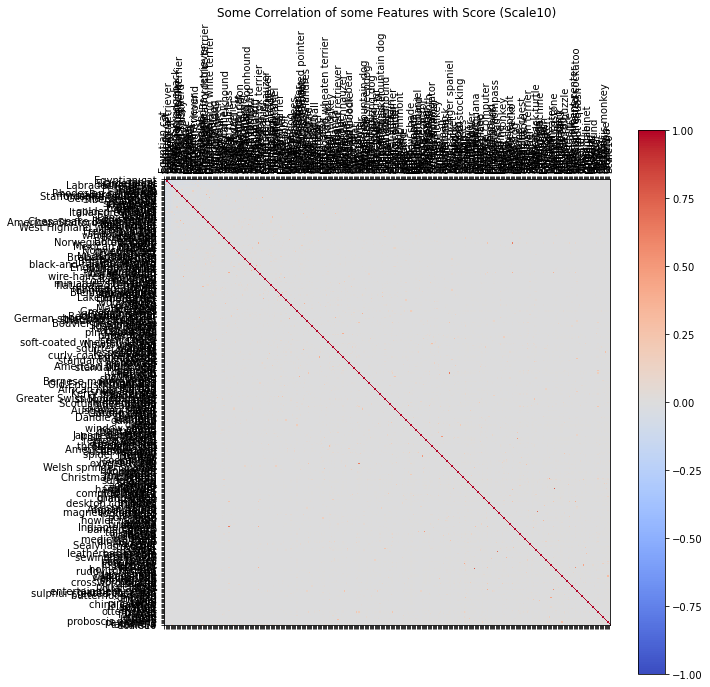

In [10]:
filename = "train_augmented_reduced.csv"
df_augmented = pd.read_csv("../data/"+filename)
takeout1 = ['Unnamed: 0', 'Id','Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
            'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',]
dff1 = df_augmented.drop(takeout1, axis=1)
dff1["id_max"] = dff1.idxmax(axis=1)
fcount = pd.DataFrame(dff1["id_max"].value_counts())
fcount = fcount.reset_index()
fcount.columns = ["name", "count"]
sf_select = fcount[fcount['count'] >0]
# sf_select = fcount[fcount['count'] >80]
sf_selected = list(sf_select['name'])

sca = 'Scale10'
features = sf_selected + [sca]
data = df_data[features]
corr = data.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.title("Some Correlation of some Features with Score (Scale10)")
plt.show()

In [ ]:
#fcount.to_csv('feature_count.csv')

### Selecting Features to Progress

In [11]:
column_names = list(df_data.columns)

to_take_out = ['Unnamed: 0', 'Id','image', 'Scale10', 'Scale5','Scale4','Scale3', 'Scale2','Pawpularity']

coln1 = 2
coln2 = coln1+12
basic_features = column_names[coln1:coln2]

gap = 21
coln1 = len(column_names) - gap -5
coln2 = coln1 + gap

palette_to_keep = column_names[coln1:coln2]

#to_keep = basic_features + sf_selected + palette_to_keep
to_keep =  basic_features + sf_selected #+ palette_to_keep
print("Number of features: ",len(to_keep))

Number of features:  372


### Splitting Data

In [12]:
#Get X and Y data - shuffle data.
#Use to to_keep when not using PCA
X = np.array(df_data[to_keep])

#Use to take out columns for PCA Analysis - othersiwe use to_keep
# X = np.array(df_data.drop(to_take_out, axis=1))

Y = df_data['Pawpularity'].values[:]

id_image = df_data['Id'].values[:]

Y10 = df_data['Scale10'].values[:]
Y5 = df_data['Scale5'].values[:]
Y4 = df_data['Scale4'].values[:]
Y3 = df_data['Scale3'].values[:]
Y2 = df_data['Scale2'].values[:]


shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y, id_image = X[shuffle], Y[shuffle], id_image[shuffle]
Y10, Y5, Y4, Y3, Y2 = Y10[shuffle], Y5[shuffle], Y4[shuffle], Y3[shuffle], Y2[shuffle]

# Define sizes for train, development and test data (0.5, 0.2, 0.3)
per_train = 0.80
per_dev = 0.18

num_images = len(Y)
train_size = int(round(num_images * per_train,0))
dev_size = int(round(num_images * per_dev,0))

# Split data based on defined sizes
test_data, test_labels, id_test = X[train_size+dev_size:], Y[train_size+dev_size:], id_image[train_size+dev_size:]
test_y10 = Y10[train_size+dev_size:]
test_y5 = Y5[train_size+dev_size:]
test_y4 = Y4[train_size+dev_size:]
test_y3 = Y3[train_size+dev_size:]
test_y2 = Y2[train_size+dev_size:]

dev_data, dev_labels, id_dev = X[train_size:train_size+dev_size], Y[train_size:train_size+dev_size], id_image[train_size:train_size+dev_size]
dev_y10 = Y10[train_size:train_size+dev_size]
dev_y5 = Y5[train_size:train_size+dev_size]
dev_y4 = Y4[train_size:train_size+dev_size]
dev_y3 = Y3[train_size:train_size+dev_size]
dev_y2 = Y2[train_size:train_size+dev_size]

train_data, train_labels, id_train = X[:train_size], Y[:train_size], id_image[:train_size]
train_y10 =  Y10[:train_size]
train_y5 =  Y5[:train_size]
train_y4 =  Y4[:train_size]
train_y3 =  Y3[:train_size]
train_y2 =  Y2[:train_size]

print(num_images)
print(train_data.shape, train_labels.shape, id_train.shape)
print(dev_data.shape, dev_labels.shape, id_dev.shape)
print(test_data.shape, test_labels.shape, id_test.shape)
print(test_y10.shape, dev_y10.shape, train_y10.shape)
print(test_y5.shape, dev_y5.shape, train_y5.shape)
print(test_y4.shape, dev_y4.shape, train_y4.shape)
print(test_y3.shape, dev_y3.shape, train_y3.shape)
print(test_y2.shape, dev_y2.shape, train_y2.shape)

9912
(7930, 372) (7930,) (7930,)
(1784, 372) (1784,) (1784,)
(198, 372) (198,) (198,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)


### Minimum Accuracy Score - RMSE when prediction is the average

In [13]:
scale = 100
Y_train, Y_dev = assign_y(scale)
avg_dev = Y_dev.mean()
print("Average score for all images: ",avg_dev)
print("Number of images in dev data: ",Y_dev.shape[0])

basic_prediction = np.repeat(avg_dev, Y_dev.shape[0])
rmse = np.sqrt(mean_squared_error(basic_prediction, dev_labels))
print("RMSE - assuming average for all images: ", rmse)

Average score for all images:  37.815582959641254
Number of images in dev data:  1784
RMSE - assuming average for all images:  20.034755770553296


### PCA Analysis All Features

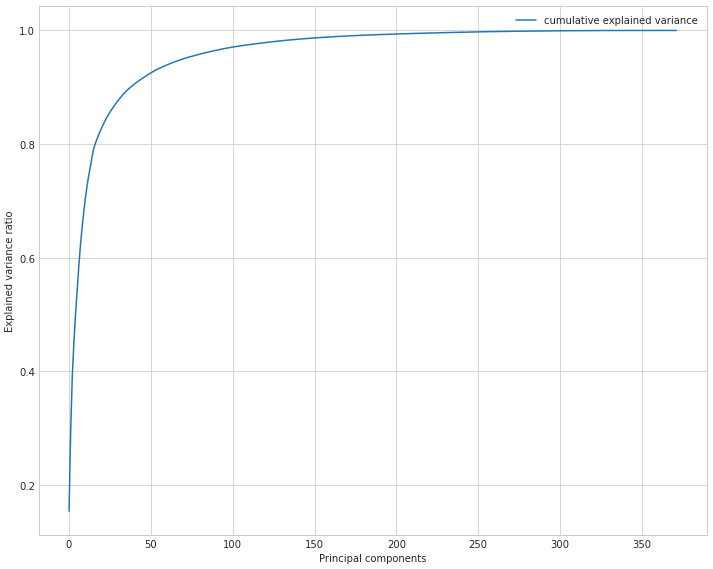

In [14]:
fp_pca = PCA()
train_data_pca = fp_pca.fit_transform(train_data)

df_summary = pd.DataFrame({"Dimension": range(1,fp_pca.explained_variance_ratio_.shape[0]+1),
                           "Var Prop Exp": fp_pca.explained_variance_ratio_,
                            "Var Cum Prop Exp (%)": np.cumsum(fp_pca.explained_variance_ratio_)})
#varplot1(p1_pca.explained_variance_)
varplot2(fp_pca.explained_variance_ratio_)

In [15]:
np.cumsum(fp_pca.explained_variance_ratio_)[100]

0.9707275261876053

In [16]:
k_list = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 150, 200]

df_summary = pd.DataFrame({"Dimension": range(1,fp_pca.explained_variance_ratio_.shape[0]+1),
                          "Var Prop Exp": fp_pca.explained_variance_ratio_,
                          "Var Cum Prop Exp (%)": np.cumsum(fp_pca.explained_variance_ratio_)})

#df_summary["Cum 2"] = df_summary['Var Prop Exp'].cumsum()

print(df_summary[df_summary['Dimension'].isin(k_list)])

     Dimension  Var Prop Exp  Var Cum Prop Exp (%)
0            1      0.153757              0.153757
1            2      0.142232              0.295989
2            3      0.097825              0.393814
3            4      0.058586              0.452400
4            5      0.049954              0.502354
9           10      0.027564              0.680881
19          20      0.006871              0.822611
29          30      0.003946              0.872962
39          40      0.002447              0.903536
49          50      0.001826              0.923588
99         100      0.000502              0.970247
149        150      0.000204              0.986608
199        200      0.000096              0.993626


### Selecting Top PCA

In [ ]:
#USE THIS CODE WHEN SELECTING TOP 100 PRINCIPAL COMPONENTS FOR THE MODELS ONLY
n_components = 100
pca_final = PCA(n_components=n_components)
train_data = pca_final.fit_transform(train_data)
dev_data = pca_final.transform(dev_data)

### Basic Model Prediction

### Best Performing Model - Random Forest

Number of features:  372
Number of estimators:  20
Criterion:  entropy
max_depth:  11
Accuracy Random Forest:  0.3116591928251121
F1_score Random Forest:  0.2261173823075915
RMSE Random Forest:  2.0845362745274136
Hamming Loss:  0.6883408071748879
RM 10 , rmse(100):  19.1275316159711


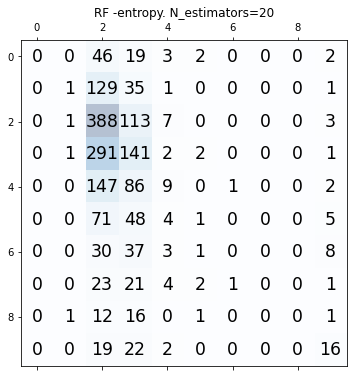

In [17]:
scale = 10

f1 = 1.333
#f1 = 1
f = 3.0184739 * f1
#f = 0

Y_train, Y_dev = assign_y(scale)
criterion_list = ["entropy", "gini"]
max_depth_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_estimators_list = [5, 10, 15, 20, 25, 30, 50, 100]
algorithm_list = ["SAMME", "SAMME.R"]
n_estimators = n_estimators_list[3]
criterion = criterion_list[0]
max_depth = max_depth_list[10]
means = mean_scale1(scale, Y_train, train_labels, f)
# means = mean_scale(scale, Y_train, train_labels)


RF_model = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion, 
                                  min_samples_split=10, max_depth=max_depth, random_state = 12345)
RF_model.fit(train_data, Y_train)
pred_RF = RF_model.predict(dev_data)
accuracy =  RF_model.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, RF_model.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(RF_model.predict(dev_data), Y_dev))
hl = hamming_loss(Y_dev, pred_RF)

print("Number of features: ", train_data.shape[1])
print("Number of estimators: ", n_estimators)
print("Criterion: ", criterion)
print("max_depth: ", max_depth)
print("Accuracy Random Forest: ", accuracy)
print("F1_score Random Forest: ", f1_score)
print("RMSE Random Forest: ", rmse)
print("Hamming Loss: ", hl)

pre_scale = predict_scale(pred_RF, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("RM",scale,", rmse(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_RF, "RF -"+criterion+". N_estimators="+str(n_estimators))

### Best Logistic Regression Model

[24.648994009058235, 30.337282919994205, 34.98528545386654, 39.53824531556829, 44.53882839195961, 49.63618622823286, 54.51430748637368, 59.43052064675339, 64.50470611041254, 71.32012202361327]
Number of features:  372
Accuracy LR:  0.29316143497757846
F1_score:  0.22303044026097277
RMSE:  2.114041249263468
Hamming Loss:  0.7068385650224215
RM 10 , rmse(100):  19.085396383534988


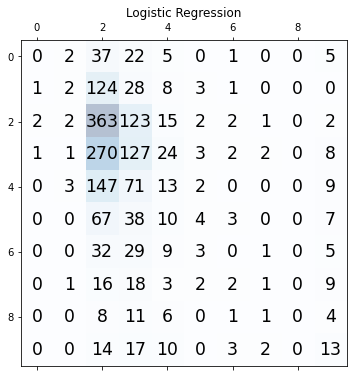

In [19]:
scale = 10
Y_train, Y_dev = assign_y(scale)

# f1 = 1.333
f1 = 1
f = 3.0184739 * f1
#f = 0
means = mean_scale1(scale, Y_train, train_labels, f)
# means = mean_scale(scale, Y_train, train_labels)
print(means)

c_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 100]
solver_list = ["liblinear", "newton-cg", "sag", "lbfgs"]
c_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
penalty = ["l1", "l2"]

logR_mod = LogisticRegression(C=4, solver="newton-cg", multi_class="auto", penalty=penalty[1], max_iter=400)
logR_mod.fit(train_data, Y_train)
pred_logR = logR_mod.predict(dev_data)
accuracy =  logR_mod.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, pred_logR, average="weighted")
rmse = np.sqrt(mean_squared_error(logR_mod.predict(dev_data), Y_dev))
hl = hamming_loss(Y_dev, pred_logR)

print("Number of features: ", train_data.shape[1])
print("Accuracy LR: ", accuracy)
print("F1_score: ", f1_score)
print("RMSE: ", rmse)
print("Hamming Loss: ", hl)


pre_scale = predict_scale(pred_logR, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("RM",scale,", rmse(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_logR, "Logistic Regression")

#### KNN - BEST PERFORMING MODEL

[25.654145817758234, 31.342434728694204, 35.990437262566545, 40.54339712426829, 45.54398020065962, 50.641338036932865, 55.51945929507369, 60.43567245545339, 65.50985791911253, 72.32527383231326]
For K:  3 ,for scale  10 , accuracy:  0.21468609865470853
For K:  3 ,for scale  10 , f1_score:  0.19762478600518216
For K:  3 ,for scale  10 , MSME:  2.551817254516559
For K:  3 ,for scale  10 , MSME(100):  20.5673750622571
20.034755770553296


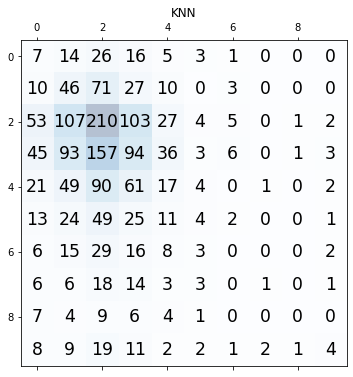

In [26]:
scale = 10
Y_train, Y_dev = assign_y(scale)
k = 3
f1 = 1.333
#f1 = 1
f = 3.0184739 * f1
#f = 0
means = mean_scale1(scale, Y_train, train_labels,f)
print(means)

# means[0] = 35.42
# means[1] = 62.08

# means[0] = 38.04819277108434
# means[1] = 38.04819277108434 + 3.0184739


metric_list = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']
metric = metric_list[1]

weights = ["uniform", "distance"]
algorithm_list = ["auto", "ball_tree", "kd_tree", "brute"]

knn_mod = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm_list[0], weights=weights[0],  metric = metric)
knn_mod.fit(train_data, Y_train)
pred_knn = knn_mod.predict(dev_data)
accuracy =  knn_mod.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, pred_knn, average="weighted")
rmse = np.sqrt(mean_squared_error(pred_knn, Y_dev))

print("For K: ",k,",for scale ",scale,", accuracy: ",accuracy)
print("For K: ",k,",for scale ",scale,", f1_score: ",f1_score)
print("For K: ",k,",for scale ",scale,", MSME: ",rmse)

pre_scale = predict_scale(pred_knn, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)
print(np.sqrt(mean_squared_error(basic_prediction, dev_labels)))

#Generate and create dataframe of Confusion Matrix
print_confusion_matrix(Y_dev, pred_knn, "KNN")

In [27]:
#LINEAR REGRESSION OF PAWPULARITY ON SELECTED SCALE (BUCKETS)
label = logR_mod.predict(train_data)
regr = LinearRegression()
regr.fit(np.array(label).reshape(len(label),1), train_labels)
print(regr.coef_)
print(regr.intercept_)

[4.75613352]
20.662551059549024


In [28]:
#ALTERNATIVE FOR LINEAR REGRESSION OF PAWPULARITY ON SELECTED SCALE (BUCKETS)
#HELP TO DEFINE FACTOR TO ADD WHEN ADJUSTING MEANS FOR BUCKETS.
import statsmodels.api as sm
new_X = sm.add_constant(label)
model = sm.OLS(train_labels,new_X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     905.7
Date:                Wed, 08 Dec 2021   Prob (F-statistic):          1.64e-188
Time:                        11:01:22   Log-Likelihood:                -34842.
No. Observations:                7930   AIC:                         6.969e+04
Df Residuals:                    7928   BIC:                         6.970e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.6626      0.619     33.398      0.0

### KNN Classifier

In [ ]:
#UPDATED KNN FOR BATCH PROCESS
def knn_adj(k, algorithm, weight, metric, scale,f, Y_train, Y_dev, means):
    knn_mod = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm, weights=weight,  metric = metric)
    knn_mod.fit(train_data, Y_train)
    pred_knn = knn_mod.predict(dev_data)
    accuracy =  knn_mod.score(dev_data, Y_dev)
    f1_score = metrics.f1_score(Y_dev, knn_mod.predict(dev_data), average="weighted")
    rmse = np.sqrt(mean_squared_error(knn_mod.predict(dev_data), Y_dev))
    hl = hamming_loss(Y_dev, pred_knn)

    pre_scale = predict_scale(pred_knn, means)
    rmse100 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
    return(accuracy, f1_score, rmse100, hl, knn_mod)

def knn_metric(k_list, algorithm, weight, metric, scale, Y_train, Y_dev, means):
    accl = []
    f1l = []
    rmse100l = []
    hll = []

    for k in k_list:
        accuracy, f1_score, rmse100, hl, knn_mod = knn_adj(k, algorithm, weight, metric, scale, f, Y_train, Y_dev, means)
        accl.append(accuracy)
        f1l.append(f1_score)
        rmse100l.append(rmse100)
        hll.append(hl)
    df_knn = pd.DataFrame()
    df_knn["K_"+str(scale)] = k_list
    df_knn["Acc_"+metric[:3]] = accl
    df_knn["f1s_"+metric[:3]] = f1l
    df_knn["rmse_"+metric[:3]] = rmse100l
    df_knn["HL_"+metric[:3]] = hll
    
    return(df_knn)

def knn_summary(Y_train, Y_dev, means, scale):
    
    metric_list = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    df_knn_summary = pd.DataFrame()
    k_list = [1, 2, 3, 4, 5, 6, 7, 8 , 9 , 10, 11, 12, 13, 14, 15, 20]
    algorithm_list = ["auto", "ball_tree", "kd_tree", "brute"]
    weights = ["uniform", "distance"]
    weight = weights[0]
    algorithm = algorithm_list[0]
    for metric in metric_list:
        df_temp = knn_metric(k_list, algorithm, weight, metric, scale, Y_train, Y_dev, means)
        if df_knn_summary.empty:
            df_knn_summary = df_temp
        else: df_knn_summary = pd.merge(df_knn_summary, df_temp, on ="K_"+str(scale))
    return(df_knn_summary)

In [ ]:
# USE TO TEST KNN BATCH 
scale = 10
f1 = 1.333
f = (3.0184739 * f1)
Y_train, Y_dev = assign_y(scale)
means = mean_scale1(scale, Y_train, train_labels, f)
df_knn_summary = knn_summary(Y_train, Y_dev, means, scale)
df_knn_summary

### NB Classifier

In [ ]:
def NB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, alpha_list, means):
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
 
    for alpha in alpha_list:
        NB_mod = BernoulliNB(alpha=alpha)
        NB_mod.fit(train_data, train_labels)
        pred_NB = NB_mod.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, pred_NB, average="weighted"))
        accuracyL.append(NB_mod.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_NB, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, pred_NB))
        
    return(accuracyL, f1_scoreL, rmseL, hll)


def NB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20, 30 ,20 ,30 ,100]

    df_NB = pd.DataFrame()
    df_NB["Alpha_"+str(scale)] = alpha_list
    accuracyL, f1_scoreL, rmseL, hll = NB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, alpha_list, means)
    df_NB["Acc_NB"] = accuracyL
    df_NB["f1s_NB"] = f1_scoreL
    df_NB["RMSE_NB"] = rmseL
    df_NB["HL_NB"] = hll
  
    return(df_NB)

In [ ]:
#USE TO TEST NB
f1 = 1.333
f = (3.0184739 * f1)

scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)

df_NB_F = NB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_NB_F

### Multinomial NB

In [ ]:
def MNB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, alpha_list, means):
    
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    for alpha in alpha_list:
        model = MultinomialNB(alpha=alpha)
        model.fit(train_data, train_labels)
        prediction = model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, prediction, average="weighted"))
        accuracyL.append(model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(prediction, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, prediction))
    
    return(accuracyL, f1_scoreL, rmseL, hll)

def MNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

    df_MNB = pd.DataFrame()
    df_MNB["Alpha_"+str(scale)] = alpha_list
    
    accuracyL, f1_scoreL, rmseL, hll = MNB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, alpha_list, means)
    df_MNB["Acc_MNB"] = accuracyL
    df_MNB["f1s_MNB"] = f1_scoreL
    df_MNB["RMSE_MNB"] = rmseL
    df_MNB["HL_MNB"] = hll

    return(df_MNB)

In [ ]:
#USE TO TEST MNB
f1 = 1.333
f = (3.0184739 * f1)

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)

df_MNB_F = MNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_MNB_F

### Gaussian NB

In [ ]:
def GNB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, smoothing_list, means):
    
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    for var_smoothing in smoothing_list:
        model = GaussianNB(var_smoothing=var_smoothing)
        model.fit(train_data, train_labels)
        prediction = model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, prediction, average="weighted"))
        accuracyL.append(model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(prediction, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, prediction))
     
    return(accuracyL, f1_scoreL, rmseL, hll)

def GNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    smoothing_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

    df = pd.DataFrame()
    df["Alpha_"+str(scale)] = smoothing_list
    
    accuracyL, f1_scoreL, rmseL, hll = GNB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, smoothing_list, means)
    df["Acc_MNB"] = accuracyL
    df["f1s_MNB"] = f1_scoreL
    df["RMSE_MNB"] = rmseL
    df["HL_MNB"] = hll
    
    return(df)


In [ ]:
#USE TO TEST GNB
f1 = 1.333
f = (3.0184739 * f1)

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
df_GNB_F = GNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_GNB_F

### LogisticRegression
Warning The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:  
- ‘newton-cg’ - [‘l2’, ‘none’]  
- ‘lbfgs’ - [‘l2’, ‘none’]  
- ‘liblinear’ - [‘l1’, ‘l2’]  
- ‘sag’ - [‘l2’, ‘none’]  
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

**max_iter was increased to 200, so it would converge**
- max_iter int, default=100
- Maximum number of iterations taken for the solvers to converge.

In [ ]:
#UPDATED FOR BATCH PROCESSING
def logR(c, solver, multi_class, penalty, max_iter, Y_train, Y_dev, means):

    if (solver != "liblinear"):
        logR_mod = LogisticRegression(C=c, solver=solver, multi_class=multi_class, max_iter=max_iter)
    else:    
        logR_mod = LogisticRegression(C=c, solver=solver, multi_class=multi_class, penalty=penalty, max_iter=max_iter)

    logR_mod.fit(train_data, Y_train)
    pred_logR = logR_mod.predict(dev_data)
    accuracy =  logR_mod.score(dev_data, Y_dev)
    f1_score = metrics.f1_score(Y_dev, logR_mod.predict(dev_data), average="weighted")
    rmse = np.sqrt(mean_squared_error(logR_mod.predict(dev_data), Y_dev))
    pre_scale = predict_scale(pred_logR, means)
    rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
    hl = hamming_loss(Y_dev, pred_logR)
    
    return(accuracy, f1_score, rmse2, hl, logR_mod)
    

def logR_c(c_list, solver, multi_class, penalty, max_iter, Y_train, Y_dev, means, scale):
    accl = []
    f1l = []
    rmse100l = []
    hll = []
    
    for c in c_list:
        accuracy, f1_score, rmse2, hl, logR_mod = logR(c, solver, multi_class, penalty, max_iter, Y_train, Y_dev, means)
        accl.append(accuracy)
        f1l.append(f1_score)
        rmse100l.append(rmse2)
        hll.append(hl)
    df_logr = pd.DataFrame()
    df_logr["C_"+str(scale)] = c_list
    df_logr["Acc_"+solver[:3]+"_"+penalty] = accl
    df_logr["f1s_"+solver[:3]+"_"+penalty] = f1l
    df_logr["rmse_"+solver[:3]+"_"+penalty] = rmse100l
    df_logr["HL_"+solver[:3]+"_"+penalty] = hll
    
    return(df_logr)

def logR_summary(Y_train, Y_dev, means, scale):
    
    penalty = ["l1", "l2"]
    solver_list = ["liblinear", "newton-cg", "sag", "lbfgs"]
    c_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5]
    #c_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    #multi_class should be 'multinomial', 'ovr' or 'auto'
    
    logr_summary = pd.DataFrame()
    for p in penalty:
        for s in solver_list:
            df_temp = logR_c(c_list, s, "auto", p, 400, Y_train, Y_dev, means, scale)
            if logr_summary.empty:
                logr_summary = df_temp
            else: logr_summary = pd.merge(logr_summary, df_temp, on ="C_"+str(scale))
    return(logr_summary)


In [ ]:
#USE TO TEST LOGISTIC REGRESSION
f1 = 1.333
f = (3.0184739 * f1)
# f = 0
means = mean_scale1(scale, Y_train, train_labels, f)
# means[0] = 35.42
# means[1] = 62.08

scale = 10
Y_train, Y_dev = assign_y(scale)

logr_summary = logR_summary(Y_train, Y_dev, means, scale)
logr_summary

### Tree

In [ ]:
def DT_model(train_data, Y_train, dev_data, Y_dev, dev_labels, criterion, max_depth_list, means):
    
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    for max_depth in max_depth_list:
        model = DecisionTreeClassifier(criterion=criterion, min_samples_split=10, max_depth=max_depth, random_state = 12345)
        model.fit(train_data, Y_train)
        prediction = model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, prediction, average="weighted"))
        accuracyL.append(model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(prediction, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, prediction))

    return(accuracyL, f1_scoreL, rmseL, hll)

def DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df = pd.DataFrame()
    criterion_list = ["entropy", "gini"]
    max_depth_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    df["maxd_"+str(scale)] = max_depth_list

    for criterion in criterion_list:
        accuracyL, f1_scoreL, rmseL, hll = DT_model(train_data, Y_train, dev_data, Y_dev, dev_labels, criterion, max_depth_list, means)
        df["Acc_"+criterion] = accuracyL
        df["f1s_"+criterion] = f1_scoreL
        df["RMSE_"+criterion] = rmseL
        df["HL_"+criterion] = hll
 
    return(df)

In [ ]:
#USE TO TEST DECISION TREE
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_DT_F = DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_DT_F

In [ ]:
#df_DT_F.to_csv('rf_summary.csv')

### Random Forest

In [ ]:
def RF_model(train_data, train_labels, dev_data, Y_dev, dev_labels, criterion, n_estimators_list, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    for n_estimators in n_estimators_list:
        RF_model = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion, min_samples_split=10, random_state = 12345)
        RF_model.fit(train_data, train_labels)
        pred_RF = RF_model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, RF_model.predict(dev_data), average="weighted"))
        accuracyL.append(RF_model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_RF, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, pred_RF))

    return(accuracyL, f1_scoreL, rmseL, hll)


def RF_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df_RF =pd.DataFrame()
    criterion_list = ["entropy", "gini"]
    n_estimators_list = [5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 80, 100]
    df_RF["n_est_"+str(scale)] = n_estimators_list
    for criterion in criterion_list:
        accuracyL, f1_scoreL, rmseL, hll = RF_model(train_data, Y_train, dev_data, Y_dev, dev_labels, criterion, n_estimators_list, means)
        df_RF["Acc_"+criterion] = accuracyL
        df_RF["f1s_"+criterion] = f1_scoreL
        df_RF["RMSE_"+criterion] = rmseL
        df_RF["HL_"+criterion] = hll
        
    return(df_RF)

In [ ]:
#USE TO TEST RANDOM FOREST
f1 = 1.333
f = (3.0184739 * f1)

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)

df_RF = RF_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_RF

### AdaBoost

In [ ]:
def AdaB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, algorithm, n_estimators_list, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    for n_estimators in n_estimators_list:
        AdaB_model = AdaBoostClassifier(n_estimators=n_estimators,algorithm=algorithm, learning_rate=1.2, random_state = 12345 )
        AdaB_model.fit(train_data, train_labels)
        
        pred_AdaB = AdaB_model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, pred_AdaB, average="weighted"))
        accuracyL.append(AdaB_model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_AdaB, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, pred_AdaB))

    return(accuracyL, f1_scoreL, rmseL, hll)

def AdaB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df_AdaB =pd.DataFrame()
    algorithm_list = ["SAMME", "SAMME.R"]
    n_estimators_list = [5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 80, 100]
    df_AdaB["n_est_"+str(scale)] = n_estimators_list

    for algorithm in algorithm_list:
        accuracyL, f1_scoreL, rmseL, hll = AdaB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, algorithm, n_estimators_list, means)
        df_AdaB["Acc_"+algorithm] = accuracyL
        df_AdaB["f1s_"+algorithm] = f1_scoreL
        df_AdaB["RMSE_"+algorithm] = rmseL
        df_AdaB["HL_"+algorithm] = hll

    return(df_AdaB)

In [ ]:
#USE TO TEST ADABOOS
f1 = 1.333
f = (3.0184739 * f1)

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)

df_AdaB = AdaB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_AdaB

### SVM

In [ ]:
def SVM_model(train_data, train_labels, dev_data, Y_dev, dev_labels, kernel, c_list, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    for c in c_list:
        if kernel == "LinearSVC":
            svm_model = svm.LinearSVC(C=c, max_iter=10000)
        elif kernel == "poly":
            svm_model = svm.SVC(kernel=kernel, C=c, degree=2, gamma=1)
        elif kernel == "rbf":
            svm_model = svm.SVC(kernel=kernel, C=c, gamma=0.7)
        else:
            svm_model = svm.SVC(kernel=kernel, C=c,)
        
        svm_model.fit(train_data, train_labels)
        
        pred_SVM = svm_model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, pred_SVM, average="weighted"))
        accuracyL.append(svm_model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_SVM, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        hll.append(hamming_loss(Y_dev, pred_SVM))
 
    return(accuracyL, f1_scoreL, rmseL, hll)

def SVM_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df_SVM =pd.DataFrame()
    kernel_list = ["linear", "rbf", "poly", "LinearSVC"]
    c_list = [0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10, 20]
    df_SVM["C_"+str(scale)] = c_list

    for kernel in kernel_list:
        accuracyL, f1_scoreL, rmseL, hll = SVM_model(train_data, Y_train, dev_data, Y_dev, dev_labels, kernel, c_list, means)
        df_SVM["Acc_"+kernel] = accuracyL
        df_SVM["f1s_"+kernel] = f1_scoreL
        df_SVM["RMSE_"+kernel] = rmseL
        df_SVM["HL_"+kernel] = hll

    return(df_SVM)

In [ ]:
#USE TO TEST SVM
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)

df_SVM_F = SVM_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_SVM_F

### Neural Network

**hidden_layer_sizestuple, length = n_layers - 2, default=(100,)**  
The ith element represents the number of neurons in the ith hidden layer.

**activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’**  
Activation function for the hidden layer.  

- ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x  
- ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).  
- ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).   
- ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)  

**solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’**  
The solver for weight optimization.  

- ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
- ‘sgd’ refers to stochastic gradient descent.
- ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

**alphafloat, default=0.0001**
L2 penalty (regularization term) parameter.

In [ ]:
def NN_model(train_data, train_labels, dev_data, Y_dev, dev_labels, activation, solver_list, alpha_list, layer_list, choice, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    hll = []
    
    if choice == "A":
        for alpha in alpha_list:
            NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, activation=activation, alpha=alpha)
            NN_model.fit(train_data, train_labels)
            pred_NN = NN_model.predict(dev_data)
            f1_scoreL.append(metrics.f1_score(Y_dev, pred_NN, average="weighted"))
            accuracyL.append(NN_model.score(dev_data, Y_dev))  
            pre_scale = predict_scale(pred_NN, means)
            rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
            hll.append(hamming_loss(Y_dev, pred_NN))
            
    elif choice == "L":
        for layer in layer_list:
            NN_model = MLPClassifier(hidden_layer_sizes=layer, max_iter=1000, activation=activation)
            NN_model.fit(train_data, train_labels)
            pred_NN = NN_model.predict(dev_data)
            f1_scoreL.append(metrics.f1_score(Y_dev, pred_NN, average="weighted"))
            accuracyL.append(NN_model.score(dev_data, Y_dev))  
            pre_scale = predict_scale(pred_NN, means)
            rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
            hll.append(hamming_loss(Y_dev, pred_NN))
            
    else:
        for solver in solver_list:
            NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=8000, activation=activation, solver=solver)
            NN_model.fit(train_data, train_labels)
            pred_NN = NN_model.predict(dev_data)
            f1_scoreL.append(metrics.f1_score(Y_dev, pred_NN, average="weighted"))
            accuracyL.append(NN_model.score(dev_data, Y_dev))  
            pre_scale = predict_scale(pred_NN, means)
            rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
            hll.append(hamming_loss(Y_dev, pred_NN))
                
    return(accuracyL, f1_scoreL, rmseL, hll)

#Note: Changing Alpha is not creating any variation in the f1_score.  Try first with L and then with S
def NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels, choice, means, scale):
    
    df_NN =pd.DataFrame()
    activation_list = ["identity", "logistic", "tanh", "relu"]
    layer_list = [(10,10,10), (5,5,5), (3,3,3), (20, 20, 20)]
    solver_list = ["lbfgs", "sgd", "adam"]
    alpha_list = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]
    
    if choice == "A":
        df_NN["Alpha_"+str(scale)] = alpha_list
    elif choice == "L":
        df_NN["Layers"+str(scale)] = layer_list
    else:
        df_NN["Solver"+str(scale)] = solver_list

    for activation in activation_list:
        accuracyL, f1_scoreL, rmseL, hll = NN_model(train_data, Y_train, dev_data, Y_dev, dev_labels, activation, solver_list, alpha_list, layer_list, choice, means)
        df_NN["Acc_"+activation] = accuracyL
        df_NN["f1s_"+activation] = f1_scoreL
        df_NN["RMSE_"+activation] = rmseL
        df_NN["HL_"+activation] = hll

    return(df_NN)

In [ ]:
#USE TO TEST NEURAL NETWORKS
f1 = 1.333
f = (3.0184739 * f1)

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)

choices = ["A", "L", "Other"] 
choice = choices[0]
df_NN_F = NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels, choice, means, scale)
df_NN_F

In [ ]:
#LOOP TO RUN ALL THE MODELS THROUGH THE DIFFERENT SCALES (scale_list)
#RESULTS TO BE STORED IN "model_summary10.xlsx"
# scale_list = [2, 3, 4, 5, 10, 100]
scale_list = [10]
file_name = "model_summary10.xlsx"
f1 = 1.333
f = (3.0184739 * f1)

for scale in scale_list:
    print(scale)
    Y_train, Y_dev = assign_y(scale)
    means = mean_scale1(scale, Y_train, train_labels, f)
    
    #df_knn = knn_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_knn = knn_summary(Y_train, Y_dev, means, scale)
    df_NB = NB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_MNB = MNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_GNB = GNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    #df_logR = LogR_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_logR = logR_summary(Y_train, Y_dev, means, scale)
    #df_DT = DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_DT = DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_RF = RF_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_AdaB = AdaB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_SVM = SVM_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_NN1 = NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels, "L", means, scale)
    df_NN2 = NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels,"S", means, scale)

    wrt_excel(file_name, "knn-"+str(scale), df_knn)
    wrt_excel(file_name, "NB-"+str(scale), df_NB)    
    wrt_excel(file_name, "MNB-"+str(scale), df_MNB)
    wrt_excel(file_name, "GNB-"+str(scale), df_GNB)
    wrt_excel(file_name, "logR-"+str(scale), df_logR)
    wrt_excel(file_name, "DT-"+str(scale), df_DT)
    wrt_excel(file_name, "RF-"+str(scale), df_RF)
    wrt_excel(file_name, "AdaB-"+str(scale), df_AdaB)
    wrt_excel(file_name, "SVM-"+str(scale), df_SVM)
    wrt_excel(file_name, "NN-"+str(scale)+"L", df_NN1)
    wrt_excel(file_name, "NN-"+str(scale)+"S", df_NN2)

### Keras - Tensorflow

- For X values: using StandardScaler ->  X_scaler = StandardScaler().fit(traind_data):  
> train_data -> X_train_scaled  
> dev_data => X_test_scaled  

- For Y values: usig label_encoder.transform(Y_train):
> Y_train -> encoded_y_train  
> Y_dev -> encoded_y_dev  

- Then convert to one-hot-encoding:
> y_train_categorical = to_catergorical(encoded_y_train)  
> y_test_categorical = to_categorical(encoded_y_dev)  

**Useful References:**  
- https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3#:~:text=Sequential%20Model%20is%20the%20easiest%20way%20to%20get,implement%20our%20own%20custom%20forward-pass%20of%20the%20model

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

#For saving and loading created models and labelencoders
import joblib
from joblib import dump, load

#For CREATING NEURAL NETWORK MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    #val_metrics = history.history['val_'+metric]
    val_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
scale = 2
Y_train, Y_dev = assign_y(scale)

# Step 0: SCALE THE DATA - TO BRING THEM TO THE SAME SCALE (MAY NOT BE NEEDED HERE AS IT IS ZEROS AND ONES)
X_scaler = StandardScaler().fit(train_data)
X_train_scaled = X_scaler.transform(train_data)
X_test_scaled = X_scaler.transform(dev_data)
#print(X_test_scaled)

# Step 1: Label-encode data set (NOT NEEDED AS Y IS ALREADY CODED AS NUMERIC)
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)

encoded_y_train = label_encoder.transform(Y_train)
encoded_y_dev = label_encoder.transform(Y_dev)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(Y_train)
y_test_categorical = to_categorical(Y_dev)

In [ ]:
#Saving the label_encoder - When using encoded, it could be saved for being uploaded later for use with model
#from sklearn.externals.joblib import dump, load  - THIS DID NOT WORK - USED THE CODE BELOW

#dump(label_encoder, 'Project_1_NN_label_encoder.bin', compress=True)

In [ ]:
#Scale = numer of output units (depending on scale being used)
#input_dim = number of features being used for the model

input_dim = len(X_test_scaled[0])
print(input_dim)
print(X_train_scaled.shape)
print(scale)

units = [200, 200]

# Create model and add layers
model = Sequential()
model.add(Dense(units=units[0], activation='relu', input_dim=input_dim))
model.add(Dense(units=units[1], activation='relu'))
#DID NOT WORK WITH SCALE + 1 WHEN SCALE EQUAL TO TWO
model.add(Dense(units=scale, activation='softmax'))

# Compile and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=2
)

In [ ]:
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
encoded_predictions = model.predict(X_test_scaled)
print(encoded_predictions)

In [ ]:
# Save the model
#model.save("FP_NN_FDF1_scale_5.h5")

### Other Neural Network - Keras

In [ ]:
# 1D Convolutional Neural Networks in Keras for Time Sequences

from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow.keras

TIME_PERIODS = 1
num_sensors = input_dim
input_shape = input_dim
num_classes = scale+1

In [ ]:
n = 500
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(n, 1, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(n, 1, activation='relu'))
model_m.add(MaxPooling1D(1))
model_m.add(Conv1D(n, 1, activation='relu'))
model_m.add(Conv1D(n, 1, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
                                                  monitor='val_loss', save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(X_train_scaled,
                      y_train_categorical,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

In [ ]:
model_loss, model_accuracy = model_m.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Save the model
#model_m.save("FP_1DCNN_FDF_scale_5.h5")

### Graphs and other tables created for the final report

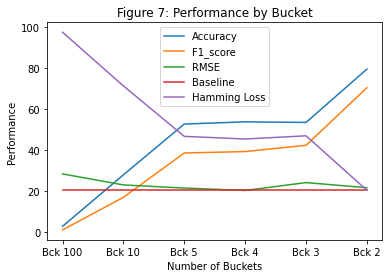

In [21]:
#CREATE AND DISPLAY GRAPH SUMMARIZING PERFORMANCE FO LOGISTIC MODEL USING DIFFERENT BUCKETS
bucket_name = ["Bck 100", "Bck 10", "Bck 5", "Bck 4", "Bck 3", "Bck 2"]
acc_bck = [2.97, 28.03, 52.75, 53.81, 53.53, 79.48]
f1s_bck = [1.23, 17.08, 38.67, 39.36, 42.41, 70.40]
rmse_bck = [28.48, 23.12, 21.60, 20.43, 24.26, 21.77]
baseline = [20.6, 20.6, 20.6, 20.6, 20.6, 20.6]
hl = [97.42, 71.3, 46.75, 45.46, 47.03, 20.52 ]
df_per = pd.DataFrame({"bucket_name": bucket_name, "Accuracy": acc_bck, "F1_score": f1s_bck, "RMSE": rmse_bck,"baseline": baseline})
#df_per.plot()
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(bucket_name, acc_bck, label ="Accuracy")
ax.plot(bucket_name, f1s_bck, label ="F1_score")
ax.plot(bucket_name, rmse_bck, label ="RMSE")
ax.plot(bucket_name, baseline, label ="Baseline")
ax.plot(bucket_name, hl, label ="Hamming Loss")
ax.set_title("Figure 7: Performance by Bucket")
ax.set_ylabel("Performance")
ax.set_xlabel("Number of Buckets")
ax.legend()
fig.patch.set_facecolor('white')
fig.savefig('bck_performance.png')   # save the figure to file
plt.show(fig)

## Exploring Model Performance using 10 Bucket Classification

After exploring different predictive models, the two best configurations were:

**(1) Logistic Regression:**
- C = 4
- solver="newton-cg“
- multi_class="auto“
- Penalty = l2
- max_iter=400

**(2) Random Forest:**
- Criterion = Entropy
- Max Depth = 11
- Num Estimators = 20
- min_samples_split=10

The models were evaluated using different number of features - the feature configurations were as follows:

- 12 Features = Original Features only.
- 21 Features = Palette Only
- 33 Features = Original Features + Palette
- 36 Features = Original Features + 24 key Image Features
- 57 Features = Original Features + Palette + 24 Key Image Features
- 100 Features = Top 100 Principal Component Features (out of 393 features) - 97.7% variance
- 372 Features = Original Features + 360 Image Features
- 393 Features = Original Features + Palette + 360 Image Features

The following graph presents the performance for the selected Logist Regression model across all the different number of features.  

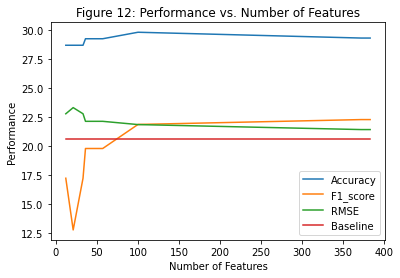

In [23]:
#CREATE AND PRESENT GRAPH FOR PERFORMANCE OF LOGISTIC REGRESSION MODEL VERSUS DIFFERENT NUMBER OF FEATURES
n_features = [12, 21, 33, 36, 57, 100, 372, 383]
rmselr = [22.8, 23.33, 22.8, 22.15, 22.15, 21.87, 21.44, 21.44]
accuracylr = [28.7, 28.7, 28.7, 29.26, 29.26, 29.82, 29.32, 29.32]
f1slr = [17.25, 12.80, 17.25, 19.81, 19.81, 21.88, 22.3, 22.3]
baselinlr = [20.6, 20.6, 20.6, 20.6, 20.6, 20.6, 20.6, 20.6]

fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(n_features, accuracylr, label ="Accuracy")
ax.plot(n_features, f1slr, label ="F1_score")
ax.plot(n_features, rmselr, label ="RMSE")
ax.plot(n_features, baselinlr, label ="Baseline")
ax.set_title("Figure 12: Performance vs. Number of Features")
ax.set_ylabel("Performance")
ax.set_xlabel("Number of Features")
ax.legend()
#plt.xticks(n_features, X)
ax.patch.set_facecolor('white')
fig.savefig('LR_performance.png')   # save the figure to file
plt.show(fig)

While the addition of features helped improve the RMSE (green line) as well as f1_score (yellow line), the RMSE was still above the baseline (20.03 - red line).

Reviewing strategies taken by other teams in the competition, it suggested that besides being able to classify the images in the ten buckets, it was important to adjust the mean value used for the bucket. Given that images were clustered between bucket 3 and 4, the mean for every bucket needed to be adjusted to reflect this.

The following table present the original mean used by bucket, and the adjusted means. The calculation is as follows:

Original Means = Average Score for Images in Train Data placed in a given bucket.
Adjusted Means 1 = For each bucket add the average for all images (37.8) and divide by two.
Adjusted Means 2 = For each Adjusted Mean 1, add 4 points (4 points was approximated by running linear regression of Buckets and Pawpularity - using the beta coefficient found).

In [24]:
original_mean = [5, 17, 26, 35, 45, 55, 65, 75, 85, 99]
adjusted_mean1 = [22, 27, 32, 36, 41, 46, 51, 56, 61, 68]
adjusted_mean2 = [x+4 for x in adjusted_mean1]
df_means = pd.DataFrame({"Bucket Number": range(1,11),
                         "Original Mean": original_mean,
                         "Adjusted Mean 1": adjusted_mean1,
                         "Adjusted Mean 2": adjusted_mean2})
df_means

,Bucket Number,Original Mean,Adjusted Mean 1,Adjusted Mean 2
0,1,5,22,26
1,2,17,27,31
2,3,26,32,36
3,4,35,36,40
4,5,45,41,45
5,6,55,46,50
6,7,65,51,55
7,8,75,56,60
8,9,85,61,65
9,10,99,68,72


Using the adjusted means, the RMSE was decreased going below the baseline of 20.03. The following graph presents the results.

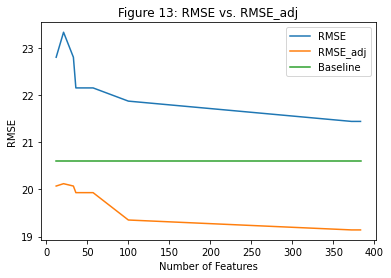

In [25]:
#CREATE AND PRESENT GRAPH OF RMSE VERSUS RMSE_ADJUSTED
n_features = [12, 21, 33, 36, 57, 100, 372, 383]
rmselr = [22.8, 23.33, 22.8, 22.15, 22.15, 21.87, 21.44, 21.44]
rmselr_adj = [20.07, 20.12, 20.07, 19.93, 19.93, 19.35, 19.14, 19.14]
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(n_features, rmselr, label ="RMSE")
ax.plot(n_features, rmselr_adj, label ="RMSE_adj")
ax.plot(n_features, baselinlr, label ="Baseline")
ax.set_title("Figure 13: RMSE vs. RMSE_adj")
ax.set_ylabel("RMSE")
ax.set_xlabel("Number of Features")
ax.legend()
fig.patch.set_facecolor('white')
fig.savefig('RMSE_adjusted.png')   # save the figure to file
plt.show(fig)